# Assignment 1
## Part B - Prediction Uncertainty with Bootstrapping
### Question 3
#### I.
 Modify the code in Activity 2 to handle bootstrapping for KNN regression

The only thing that needs to be change to handle KNN regression in the bootstrapper code is to change the classifier error to a RMSE error return function. Since sampling and all other bootstrap steps are the same.
I will use my own functions to something similar to what is shown in Activity 2. 


In [1]:
# Dependencies
require(ggplot2)
require(reshape2)

# Utilities
udf_utils_castFlexibleDataFrame <- function(object) {

    # Utility function that coerces vectors, dataframes, matrices and other enumerable types to data frame.

    cNames_ <- colnames(object) # get object column names.
    dfObj_ <- as.data.frame(object) # cast object as data frame.

    if (is.null(cNames_)) {
        # if no column names assign generic.
        for (i in 1:length(dfObj_)) {
            colnames(dfObj_)[i] <- paste0("c", i)
        }
    }
    return(dfObj_)
}

udf_utils_rootMeanSquareError <- function(predVals, actVals) {

    # this function returns teh root mean square error of predicted values and actual values. 

    predVals <- udf_utils_castFlexibleDataFrame(predVals) 
    actVals <- udf_utils_castFlexibleDataFrame(actVals)

    if (nrow(predVals) != nrow(actVals)) {
        stop("differring predictions and actual values.")
    }

    eW_ <- (sum((predVals - actVals) ^ 2)) / 2

    eRMS_ <- sqrt(2 * (eW_) / nrow(predVals))

    return(eRMS_)

}

udf_utils_checkLabelsObj <- function(labels) {

    # utility function for checking label array object for comformance.

    # for the regresser, we are looking for numeric types.
    # handle data frames.
    if (class(labels) == "data.frame") {
        if (ncol(labels) == 1) {
            # if dataframe object is passed, and has the length of one column, try cast as numeric.
            # any non numeric characters will be forced NA. Error out.
            suppressWarnings(labels <- as.numeric(labels))

            # atthe risk of falling through many if conditions
            if (sum(is.na(labels)) > 0) {
                stop("Non numeric values found in label set. Non numerics cannot be implemented in regressor.")
            }
        } else {
            stop("labels must be a one dimensional array!")
        }
    } else {
        # if not data frame, 
        suppressWarnings(labels <- as.numeric(labels))

        if (sum(is.na(labels)) > 0) {
            stop("Non numeric values found in label set. Non numerics cannot be implemented in regressor.")
        }
    }

    return(labels)
}

udf_knn <- function(trainingSet, trainingLabels, testSet, K = 3) {

    #store Lengths
    lnTrDt <- nrow(as.data.frame(trainingSet)) # training data
    lnTrLb <- nrow(as.data.frame(trainingLabels)) # training label
    lnTsDt <- nrow(as.data.frame(testSet)) # test set data

    # convert the passed in objects to data frames.
    trainingSet <- udf_utils_castFlexibleDataFrame(trainingSet)
    testSet <- udf_utils_castFlexibleDataFrame(testSet)

    # check labels object conforms or force conform.
    trainingLabels <- udf_utils_checkLabelsObj(trainingLabels)


    # quick check to see nrows match
    if (lnTrDt != lnTrLb) {
        stop("lengths of training and test sets do not match!")
    }
   
    # calc distance matrix
    
    # subset the test set data points and their distance to the training set data points.
    dist_ <- as.matrix(dist(rbind(testSet, trainingSet)))[1:lnTsDt, (lnTsDt + 1):(lnTsDt + lnTrDt)] 

    ## for each test sample...
    pred_ <- as.numeric() # instantiate prediction container
    for (i in 1:lnTsDt) {
        ## get the distances 
        nn <- as.data.frame(sort(dist_[i,], index.return = TRUE))[1:K, 2]

        ## get the mean of the k nearest neigbours. 
        pred_[i] <- (mean(trainingLabels[nn]))
    }
    return(pred_)
}

Loading required package: ggplot2
Loading required package: reshape2


In [2]:
## Implement the bootstrap code.

# Implement a bootstrap sampler.
udf_bootstrapIndexer <- function(x = 100, sampleSize = x, times = 100, Seed = 1234) {
    
    # this function applies bootstrap sampling and returns a MATRIX OF INDICES with the sample pattern.

    # develop container for matrices
    index_ <- matrix(nrow = times, ncol = sampleSize)
    set.seed(Seed)
    for (t in 1:times) {
        index_[t,] <- sample(x = x, size = sampleSize, replace = TRUE)

    }
    return(index_)
}

# Implement a bootstrap function to handle regression
udf_knnBootstrapErr <- function(trData, trLabels, tsData, tsLabels, sampleSizeN = 25, timesL = 100, K = 1:20, Seed = 1234) {

    # generate bootstrap indexes
    indexes_ <- udf_bootstrapIndexer(nrow(trData), sampleSizeN, timesL, Seed)

    # container
    err_ <- data.frame('K' = 0, 'L' = 0, 'test' = rep(0, timesL * length(K)))

    # instantiate iterator tracker
    i <- 1
    for (k in K) {

        for (l in 1:timesL) {

            #get the indices from the bootstrap sampling
            index_ <- indexes_[l,]

            # save the value of k & l
            err_[i, 'K'] = k
            err_[i, 'L'] = l

            # calculate RMSE and store
            err_[i, 'test'] <- udf_utils_rootMeanSquareError(udf_knn(trData[index_,], trLabels[index_], tsData[index_,], k), tsLabels[index_])

            # increment iterator count.
            i <- i + 1
        }
    }
    return(err_)
}


#### II.
Load Task1B_train.csv and Task1B_test.csv sets. Apply your bootstrapping for
KNN regression with times = 100 (the number of subsets), size = 25 (the size of each
subset), and change K=1,..,20 (the neighbourhood size). Now create a boxplot where
the xaxis is K, and the yaxis is the average error (and the uncertainty around it)
corresponding to each K. Save the plot as fig.1.b.1.pdf and attach it to your report.

Saving 7 x 7 in image


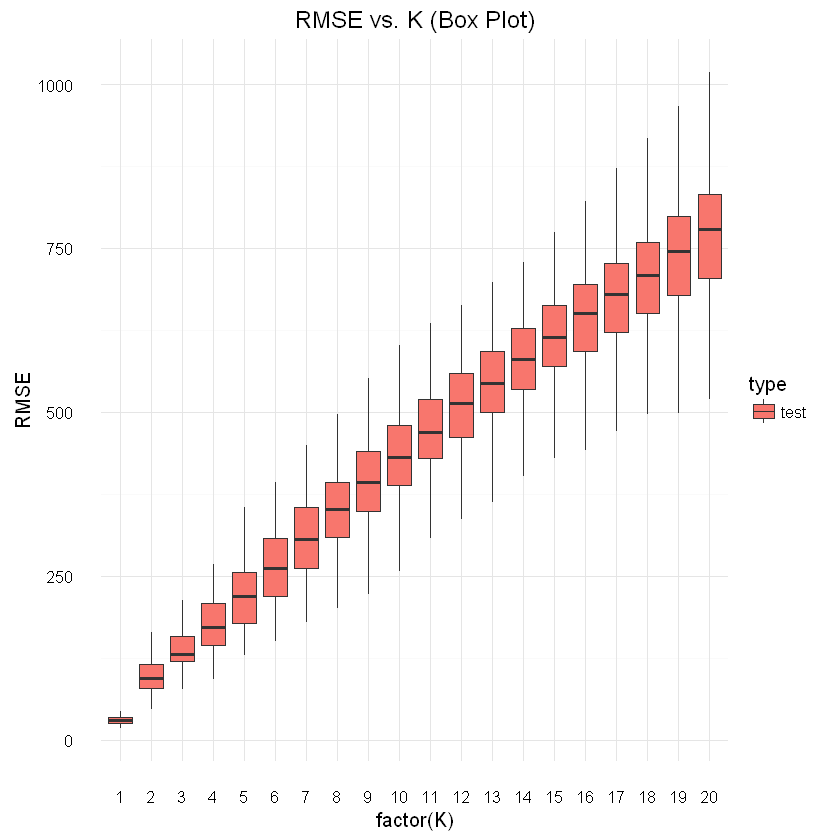

In [3]:
# load datasets
tr_dt <- read.csv("./assessments_datasets/Task1B_train.csv")
ts_dt <- read.csv("./assessments_datasets/Task1B_test.csv")

# subset training and test variables. (explicitly pass in labels)
trainSet <- subset(tr_dt, select = -c(y))
testSet <- subset(ts_dt, select = -c(y))

#run bootstrap and get errors
errs_ <- udf_knnBootstrapErr(trainSet, tr_dt$y, testSet, ts_dt$y, 25, 100)

# melt the data frame
errsMelt_ <- melt(errs_, id = c('K', 'L'))

# recast names
names(errsMelt_) <- c("K", "L", "type", "RMSE")

# make the plot
ggplot(data = errsMelt_[errsMelt_$type == 'test',], aes(factor(K), RMSE, fill = type)) + geom_boxplot(outlier.shape = NA) + scale_color_discrete(guide = guide_legend(title = NULL)) + ggtitle('RMSE vs. K (Box Plot)') + theme_minimal()

# save the plot
ggsave("fig.1.b.1.pdf", device = "pdf")

#### III.
Based on fig.1.b.1.pdf,how does the test error and its uncertainty behave as K
increases?

The error and the uncertainty in the error seems to be increasing as K is increasing.

#### IV.
Load Task1B_train.csv and Task1B_test.csv sets. Apply your bootstrapping for
KNN regression with K=10 (the neighbourhood size), size = 25 (the size of each
subset), and change times = 10, 20, 30,.., 200 (the number of subsets). Now create a
boxplot where the x-axis is ‘times’, and the y-axis is the average error (and the
uncertainty around it) corresponding to each value of ‘times’. Save the plot as
fig.1.b.2.pdf and attach it to your report.


In [4]:
# load datasets
tr_dt <- read.csv("./assessments_datasets/Task1B_train.csv")
ts_dt <- read.csv("./assessments_datasets/Task1B_test.csv")

# subset training and test variables. (explicitly pass in labels)
trainSet <- subset(tr_dt, select = -c(y))
testSet <- subset(ts_dt, select = -c(y))

Saving 7 x 7 in image


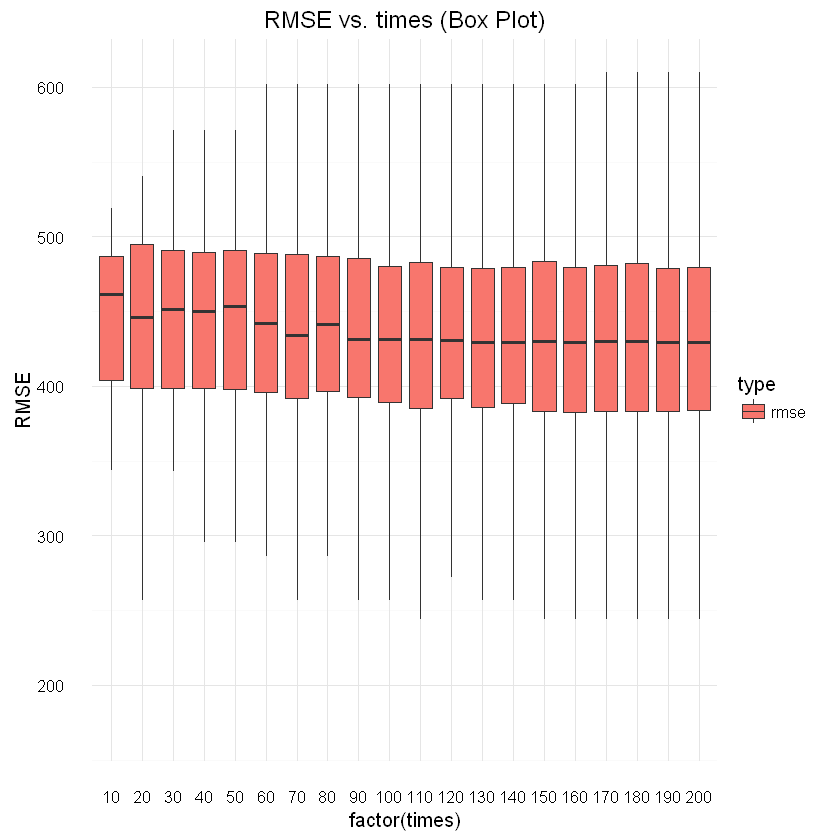

In [5]:
# make our time sequence as per required.
timesL <- seq(10, 200, 10)

# container vector for generation of data frame/ 
timesVec <- c()

# get iteration length
for (i in timesL) {
    for (ii in 1:i) {
        timesVec <- append(timesVec,i)
    }
}

# create a data frame with iteration length
errs_ <- data.frame("times" = timesVec, "rmse" = rep(0, length(timesVec)))

# create an iterator for keeping track of rows.
r <- 1


for (i in timesL) {
    # create bootstrap indexes with each size times l
    indexes_ <- udf_bootstrapIndexer(nrow(trainSet), 25, i)
    for (ii in 1:i) {
        # make index
        index_ <- indexes_[ii,]
        # make predictions
        preds_ <- udf_knn(trainSet[index_,], tr_dt$y[index_], testSet[index_,], K = 10)
        # get the rmse
        rmse_ <- udf_utils_rootMeanSquareError(preds_, ts_dt$y[index_])

        # store it in teh dataframe
        errs_[r, 'rmse'] <- rmse_

        # increment iterator
        r <- r + 1
    }

}


errsMelt_ <- melt(errs_, id = c('times'))

names(errsMelt_) <- c("times", "type", "RMSE")

# make the plot
ggplot(data = errsMelt_[errsMelt_$type == 'rmse',], aes(factor(times), RMSE, fill = type)) + geom_boxplot(outlier.shape = NA) + scale_color_discrete(guide = guide_legend(title = NULL)) + ggtitle('RMSE vs. times (Box Plot)') + theme_minimal()

# save the plot
ggsave("fig.1.b.2.pdf", device = "pdf")

#### V.
Based on fig.1.b.2.pdf,how does the test error and its uncertainty behave as the
number of subsets in bootstrapping increases?

It seems that the error seems to drop, but stabilises after the sampling time hits around 90. The uncertainty doesnt seem to be too greatly affected by this.